# Recommender Systems

Recommender systems are useful for recommending users items based on their past preferences. Recommender systems are generally classified into the following categories:

- **Content-based** based on similarity of item attributes (e.g. keywords, categories) and users preferences: For instance, if a user liked Item A, the recommender system would recommend items with similar characteristics. If we would talk about movies, those characteristics would include producer, genre, etc... Typically, this can be done with a binary classification supervised algorithm.


- **Collaborative filtering**, which calculates similarity from interactions (e.g. ratings, number of purchases, likes, etc.). This process finds customers who have similar preferences, and then gives recommendations to one customer from a set of items that are new to that particular customer and preferred by other customers with a similar profile. The system makes an assumption that users with similar movie watching habits have similar preferences in general. It finds users who watch videos similar to those the user watches, then identifies videos those similar users have watched, but which the first user has not. There are 3 approaches to this; user-user collaborative filtering, item-item collaborative filtering and matrix factorization.


- New approaches and usually more powerful are **Hybrid systems**, which combine the two aforementioned methods.

<img src="data/image.png" width=600>

The above diagram categorises in detail the different methodologies for building a recommender system.

In context to the `movieLens` that will be used later as a sample dataset:
- We will suggest different movies based on the content similarity, e.g. genre, cast, etc. applying an item-content filtering
- We could also compare the user metadata, such as age and gender, and suggest items to the user that similar users have liked. In that case, we would use a user-content filtering. The `movielens` dataset doesn't contain any user content data, so we will build only an item-item collaborative filtering.

**Memory-based** content filtering

In memory-based methods there is no model that learns from the data to predict. A pre-computed matrix of similarities is constructed that can be used for movie predic

__Load the datasets in three different pandas dataframes__

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load movies data
movies = pd.read_csv('data/movies.csv')
tags = pd.read_csv('data/tags.csv')
ratings = pd.read_csv('data/ratings.csv')

display(movies.head())
display(tags.head())
display(ratings.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


__remove the '|' that separates the different genres of movies and replace with an empty space__

In [13]:
movies['genres'] = movies['genres'].str.replace('|',' ')

__Filter the `ratings` dataframe, to have only movies that have received a rating__

In [14]:
# Filter the movies df
movies = movies[movies.movieId.isin(ratings.movieId.unique().tolist())]
movies.shape

(9724, 3)

# Feature engineering

We're gonna create a new feature called `metadata`, that merges **all the text data information** we have about a movie : the genre and the tags

__Merge the `movies` and `tags` data frames__

In [15]:
# Merge
merged = pd.merge(movies, tags, on='movieId', how='left')
# Drop useless columns.
merged.head()

,movieId,title,genres,userId,tag,timestamp
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,336.0,pixar,1.139046e+09
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,474.0,pixar,1.137207e+09
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,567.0,fun,1.525286e+09
3,2,Jumanji (1995),Adventure Children Fantasy,62.0,fantasy,1.528844e+09
4,2,Jumanji (1995),Adventure Children Fantasy,62.0,magic board game,1.528844e+09


__Create a new dataframe with the `metadata` column, containing a string of both tags AND genres merged together__

So you have to merge **tags first** together per movie. And **then** merge the combined tags with the **genres** column.

For example the `metadata` column of the movie Toy Story will be `pixar pixar fun Adventure Animation Children Comedy Fantasy`

In [16]:
# Create a new df with a new metadata column from tags and genres.
merged.fillna("", inplace=True)
merged = pd.DataFrame(merged.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
df = pd.merge(movies, merged, on='movieId', how='left')
df['metadata'] = df[['tag', 'genres']].apply(lambda x: ' '.join(x), axis = 1)

df.head()

,movieId,title,genres,tag,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun,pixar pixar fun Adventure Animation Children C...
1,2,Jumanji (1995),Adventure Children Fantasy,fantasy magic board game Robin Williams game,fantasy magic board game Robin Williams game A...
2,3,Grumpier Old Men (1995),Comedy Romance,moldy old,moldy old Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance,,Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy,pregnancy remake,pregnancy remake Comedy


## Create a content latent matrix from metadata

### Count Vectorizer

Next we need to transform the metadata text to vectors, in order to feed it to our machine learning algorithms. Machine Learning models don't understand text data so we need to encode it.

We're gonna use the `CountVectorizer` to encode the metadata column. 

Create a new dataframe `count_df` with the vectors you get from this count transformation. Every line is gonna be the frequency vector for this specific movie.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df['metadata'])
count_df = pd.DataFrame(count_matrix.toarray(), index=df.index.tolist())
count_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Dimensionality reduction

Each movie metadata was transformed into a vector of length 1675! (approximately)

As we saw in previous lessons, we can apply dimensionality reduction methods to describe the data (movies) without much loss of information. Truncated singular value decomposition (SVD) is another advanced tool to reduce dimensions.

Contrary to PCA, this estimator **does not center the data before computing the singular value decomposition**. This means it can work with **sparse matrices efficiently**. In particular, truncated SVD works on term count/frequency matrices. In that context, it is known as latent semantic analysis (LSA).

You can look at `TruncatedSVD` class in scikit learn but it's the same principle as PCA

__👉apply the truncated SVD with a reduced number of features (say 25) to reduce the dimension of your Count matrix__

In [18]:
from sklearn.decomposition import TruncatedSVD

# Apply SVD
svd = TruncatedSVD(n_components=25)
latent_df = svd.fit_transform(count_df)

👉**Plot the cumulative explained variance ratio as a function of the number of components**

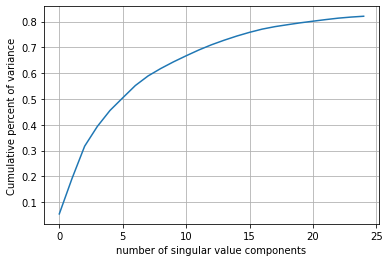

In [19]:
# Plot variance as a function of the number of components.
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

We can see that with only the first 25 components (from initially about 1700) we can explain **more than 80%** of the variance, which suffices for our study purposes.

👉**save the 25 first components of this matrix into a new `latent_df` dataframe, indexed by the titles from the movies**

In [20]:
# keep the first 25 number of latent components.
n = 25 
latent_df = pd.DataFrame(latent_df[:,0:n], index=df.title.tolist())
latent_df.shape

(9724, 25)

## Create a latent matrix from user ratings

Except from the metadata we have another valuable source of information, **the user ratings**. 

A recommender system can recommend a movie that is similar on the basis of user ratings (item-item collaborative filtering).

👉**We prepare the dataset below to have movies as lines, userids as columns**

In [21]:
# Merge
ratings1 = pd.merge(movies[['movieId']], ratings, on="movieId", how="right")
# Pivot
ratings2 = ratings1.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)
display(ratings2.head())
ratings2.shape

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


(9724, 610)

We just created a dataset with movies as vectors of length 9724.

👉**Once again, we will apply SVD to the `ratings2` dataframe, so as to keep only the first 200 components. Call this dataframe `latent_df_2`**

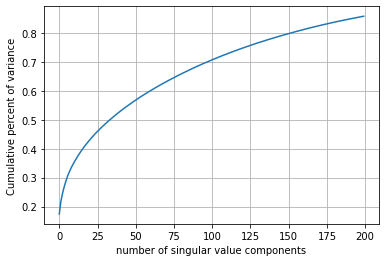

In [22]:
svd = TruncatedSVD(n_components=200)
latent_df_2 = svd.fit_transform(ratings2)
 
# Plot variance as a function of the number of components.
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

👉We reindex by the film title

In [23]:
latent_df_2 = pd.DataFrame(latent_df_2, index=df.title.tolist())
latent_df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),37.649828,-6.380094,14.994617,0.286947,-1.887147,4.790048,8.807631,-2.198626,1.153307,1.387547,...,0.968577,-2.396448,-1.125926,-1.278974,0.235436,-0.932816,-0.609286,4.117264,-1.006491,-1.297519
Jumanji (1995),20.596193,-0.477880,10.865916,-8.635795,-3.072411,-0.517149,4.359214,-3.821415,-3.394122,0.236481,...,-0.297745,-2.216036,1.228537,-0.355461,-0.977061,0.413164,-0.503092,-0.234906,-0.446106,-1.566494
Grumpier Old Men (1995),8.504182,-5.714924,3.441693,-6.382810,0.024162,-0.783432,-1.423028,-0.542295,3.270653,1.897242,...,-0.536320,-0.328730,-0.174670,0.391957,0.583872,0.733254,1.183663,-0.751860,0.164735,0.954187
Waiting to Exhale (1995),0.465720,-0.828101,0.954583,-0.239080,-0.735695,-0.877414,0.214719,-0.527369,0.079466,0.015619,...,0.281394,0.098443,-0.045881,0.122504,-0.156498,-0.507556,-0.151004,-0.126025,-0.146671,-0.380145
Father of the Bride Part II (1995),6.071045,-2.673536,4.698195,-4.415807,-3.714220,-1.673627,1.297652,-1.308030,1.325732,1.229584,...,-0.370395,0.735311,0.053551,-0.264906,-0.324561,-0.223225,0.167150,0.245444,-0.209060,-0.837346


## Apply cosine similarity in content and colaborative matrices

Next, we will use a similarity measure to find the top $N$ **most similar movies to "Toy Story"** based on the filtering methods we created. Cosine similarity is one of the similarity measures we can use (`sklearn.metrics.pairwise.cosine_similarity`)

__👉Compute the cosine similarity of a sample movie ("Toy Story") to both content and collaborative latent matrices.__

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

# Get the latent vectors for "Toy Story" from content and collaborative matrices
v1 = np.array(latent_df.loc['Toy Story (1995)']).reshape(1, -1)
v2 = np.array(latent_df_2.loc['Toy Story (1995)']).reshape(1, -1)

# Compute the cosine similartity of this movie with the others in the list
sim1 = cosine_similarity(latent_df, v1).reshape(-1)
sim2 = cosine_similarity(latent_df_2, v2).reshape(-1)

We can also create a hybrid filter, which is an average measure of similarity from both content and collaborative filtering. 

`hybrid-similarity = (content-similarity + collab-similarity) / 2`

__Calculate the average measure of both content and collaborative__

In [25]:
hybrid = ((sim1 + sim2)/2.0)

__Create a dataframe with the final similarities to Toy Story__

In [26]:
dictDf = {'content': sim1 , 'collaborative': sim2, 'hybrid': hybrid} 
recommendation_df = pd.DataFrame(dictDf, index = latent_df.index)

__Sort your dataframe by most similar by collaborative similarity__

In [27]:
recommendation_df.sort_values('collaborative', ascending=False, inplace=True)
recommendation_df.head(10)

,content,collaborative,hybrid
Toy Story (1995),1.000000,1.000000,1.000000
Toy Story 2 (1999),0.946793,0.635881,0.791337
Independence Day (a.k.a. ID4) (1996),0.198071,0.618242,0.408156
Jurassic Park (1993),0.198980,0.617346,0.408163
Star Wars: Episode IV - A New Hope (1977),0.094537,0.597976,0.346257
Mission: Impossible (1996),0.222302,0.596937,0.409620
Shrek (2001),0.912426,0.585546,0.748986
Forrest Gump (1994),0.220644,0.580756,0.400700
"Lion King, The (1994)",0.526500,0.579842,0.553171
Star Wars: Episode VI - Return of the Jedi (1983),0.190944,0.579557,0.385250


You should see Toy Story as the most similar movie of course (similarity of 1 for every column)

__You can sort on contant as well as hybrid and see which one gives the best recommentation__

In [28]:
recommendation_df.sort_values('hybrid', ascending=False, inplace=True)
recommendation_df.head(10)

,content,collaborative,hybrid
Toy Story (1995),1.000000,1.000000,1.000000
Toy Story 2 (1999),0.946793,0.635881,0.791337
"Monsters, Inc. (2001)",0.999658,0.552046,0.775852
Shrek (2001),0.912426,0.585546,0.748986
"Bug's Life, A (1998)",0.896111,0.532794,0.714453
Finding Nemo (2003),0.895507,0.527202,0.711354
Antz (1998),0.999658,0.403864,0.701761
Toy Story 3 (2010),0.913228,0.484938,0.699083
Aladdin (1992),0.795151,0.573844,0.684498
Ice Age (2002),0.895871,0.430141,0.663006
